In [1]:
# https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense,Conv2DTranspose
from tensorflow.keras.layers import Flatten, Lambda, Reshape, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy

In [25]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [30]:
# Get and Set some parameters
H = x_train.shape[1]
W = x_train.shape[2]
C = 1  # number of channels
latent_len = 16 # number of components in the latent space (length)

In [31]:
x_train = x_train.reshape((-1, H, W, C))
x_test  = x_test.reshape((-1, H, W, C))

# Print info
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Create VCAE

In [ ]:
import tensorflow as tf
tf.random.normal(shape=(10, 7, 7, 16))

In [32]:
# Sampling function with reparametrization trick
def sampling(args):
    mean, var = args
    batch_size = tf.shape(mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, 7, 7, 16))
    return mean + tf.exp(var) * epsilon

In [43]:
# Create Encoder
in_layer = Input(shape=(H, W, C), name='IN')

x = Conv2D(32, 3, strides=2, activation='relu', padding='same')(in_layer)
x = Conv2D(16, 3, strides=2, activation='relu', padding='same')(x)
x = Flatten()(x)

# Latent vector
z_mean    = Dense(latent_len, name='Z_MEAN')(x)
z_log_var = Dense(latent_len, name='Z_LOG_VAR')(x)
z = Lambda(sampling, name='Z')([z_mean, z_log_var])

# final encoder
encoder = Model(in_layer, z, name='ENCODER')
encoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN (InputLayer)                 [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 32)   320         IN[0][0]                         
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 16)     4624        conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           conv2d_9[0][0]                   
____________________________________________________________________________________________

In [48]:
# Create decoder
decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
x = Dense(784, activation='relu')(decode_in_layer)
x = Reshape((7, 7, latent_len))(x)

x = Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)

decode_out_layer = Conv2DTranspose(C, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')
decoder.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN_DECOD (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               13328     
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 1)         289       
Total params: 20,577
Trainable params: 20,577
Non-trainable params: 0
_______________________________________________________

In [49]:
# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
cvae = Model(in_layer, out_layer, name='CVAE')
cvae.summary()

Model: "CVAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN (InputLayer)              [(None, 28, 28, 1)]       0         
_________________________________________________________________
ENCODER (Model)              (None, 16)                30064     
_________________________________________________________________
DECODER (Model)              (None, 28, 28, 1)         20577     
Total params: 50,641
Trainable params: 50,641
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Plot model
#from tensorflow.keras.utils import plot_model
#plot_model(cvae, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [51]:
# Define custom loss for VAE
def vae_loss(y, x_hat):
    # Reconstruction
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat))
    # DKL divergence
    dkl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + dkl_loss

In [52]:
# Compile and train model
cvae.compile(optimizer='adam', metrics=['accuracy'], loss=vae_loss, experimental_run_tf_function=False)
cvae.fit(x_train, x_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 80s 2ms/sample - loss: 0.3098 - accuracy: 0.8071 - val_loss: 0.2671 - val_accuracy: 0.8093
Epoch 2/10
48000/48000 [==============================] - 82s 2ms/sample - loss: 0.2667 - accuracy: 0.8087 - val_loss: 0.2646 - val_accuracy: 0.8093
Epoch 3/10
48000/48000 [==============================] - 75s 2ms/sample - loss: 0.2650 - accuracy: 0.8087 - val_loss: 0.2636 - val_accuracy: 0.8093
Epoch 4/10
48000/48000 [==============================] - 75s 2ms/sample - loss: 0.2643 - accuracy: 0.8087 - val_loss: 0.2631 - val_accuracy: 0.8093
Epoch 5/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.2639 - accuracy: 0.8086 - val_loss: 0.2628 - val_accuracy: 0.8092
Epoch 6/10
17664/48000 [==========>...................] - ETA: 45s - loss: 0.2641 - accuracy: 0.8081

KeyboardInterrupt: 

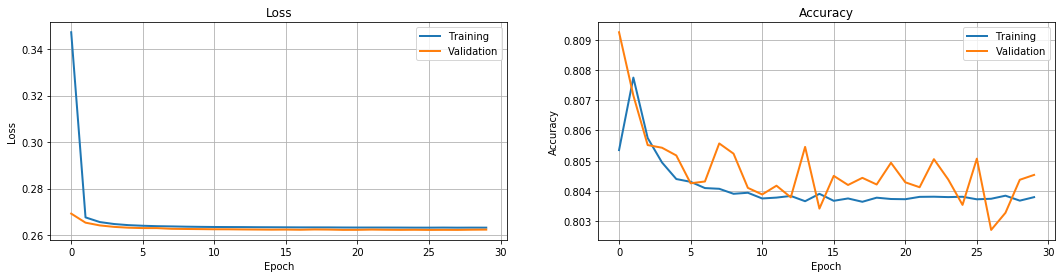

In [18]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(cvae.history.history['loss'], label='Training', linewidth=2)
plt.plot(cvae.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(cvae.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(cvae.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [19]:
# Predict reconstruction error on test data
test_loss = cvae.evaluate(x_test, x_test)
print(f"Test loss {test_loss[0]:.4f} -- Test accuracy {test_loss[1]:.4f}")

x_test_hat = cvae.predict(x_test)

10000/10000 [==============================] - 3s 324us/sample - loss: 0.2628 - accuracy: 0.8027
Test loss 0.2628 -- Test accuracy 0.8027


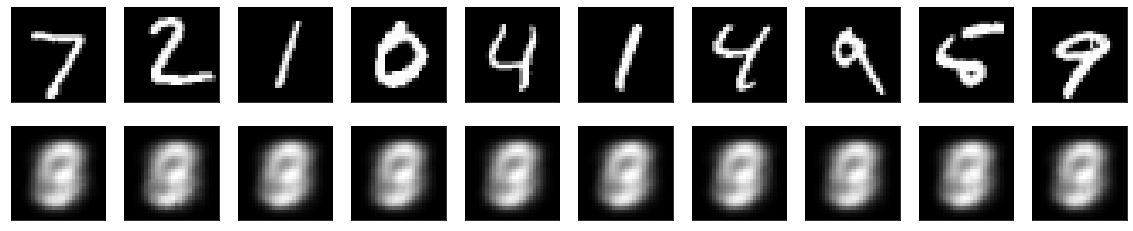

In [20]:
# Show a few reconstruction examples
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(x_test_hat[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
# Compute latent space
test_latent = encoder.predict(x_test)
print(test_latent.shape)

(10000, 16)


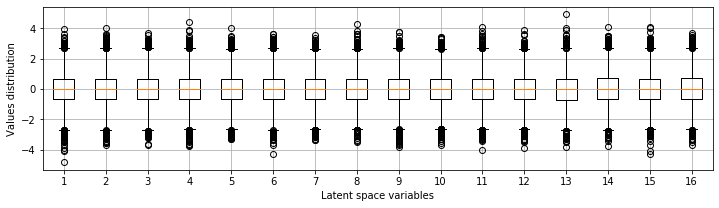

In [23]:
# Plot distribution of latent space
plt.figure(figsize=(12, 3))
plt.boxplot(test_latent)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [66]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

ValueError: Error when checking input: expected IN_DECOD to have shape (16,) but got array with shape (2,)